# fscLVM tutorial 

In this notebook we illustrate how f-scLVM can be used to identify biological drivers on the mESC cell cycle staged dataset.

First, we load some modules and set some directories

In [8]:
import os
import fscLVM
import pdb
from fscLVM import plotFactors, plotFA, saveFA, dumpFA
%pylab inline

#specify where the hdf5 file is
data_dir = '../data/'
out_dir = './results'



Populating the interactive namespace from numpy and matplotlib


f-scLVM expects an expression file, typically with log transformed gene expression values  as well as a gene set annotation. These data can be provided as single hdf5 file, which can be generated using separate R scripts (in the R folder). Alternatively, the expression matrix and the annotation can be loaded as text files in python. 






# Loading raw expression data and gene set annotations

By default we here load the MsigDB annotation, which needs to be downloaded separately from the Broad web page. 

In [2]:
####
#Option 1: load a pre-defined hdf5 file
#We provide an (optional) hdf file with the required data - this was generated using
#the R script write_fscLVM.R in the R folder
if 1:
    dFile = os.path.join(data_dir,'Buettneretal2015.hdf5')
    data = fscLVM.load_hdf5(dFile)
    annoDB = 'MsigDB'
####

####
#Option 2: load the annotation and the data directly
if 0:
    #Annotation file
    annoFile = os.path.join(data_dir,'h.all.v5.2.symbols.gmt.txt') #MSigDB
    annoDB   = 'MsigDB'
    if not os.path.exists(annoFile):
        raise Exception("MsigDB annotation file needs to be downloaded manually")
    #Note: the license of MSigDB does not permit redistribution of the raw annotation files.
    #Please register at http://software.broadinstitute.org/gsea/msigdb and download the
    #hallmark gene sets and place the file in data folder.

    #annoFile = os.path.join(data_dir,'c2.cp.reactome.v4.0.symbols.gmt.txt') #REACTOME
    #annoDB   = 'REACTOME'

    #dataFile: csv file with log expresison values
    dataFile = os.path.join(data_dir,'Buettneretal.csv.gz')
    data = fscLVM.utils.load_txt(dataFile=dataFile,annoFile=annoFile,annoDB=annoDB)
####

#print statistics for the loaded dataset
print ("Loaded {:d} cells, {:d} genes".format(data['Y'].shape[0],data['Y'].shape[1]))
print ("Annotation: {:d} terms".format(len(data['terms'])))

Loaded 182 cells, 6635 genes
Annotation: 50 terms


# Initializiting the f-sclVM model

In [3]:
#I: indicator matrix that assigns genes to pathways
I = data['I']
#Y: log expresison values 
Y = data['Y']
#terms: ther names of the terms
terms = data['terms']

#initialize FA instance, here using a Gaussian noise model and fitting 3 dense hidden factors
FA = fscLVM.initFA(Y, terms,I,noise='gauss', nHidden=3, 
                   pruneGenes=True, minGenes=15)

## Model training

In [4]:

#model training
FA.train()

#print diagnostics
FA.printDiagnostics()

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
Converged after 701 iterations
Maximally  4.6875 % Genes per factor changed.


Next, we plot the results, including  factor relevance, gene set augmentation and a scatter plot of the two most relevant factors, in this case G2M Checkpoint and P53 Pathway. 

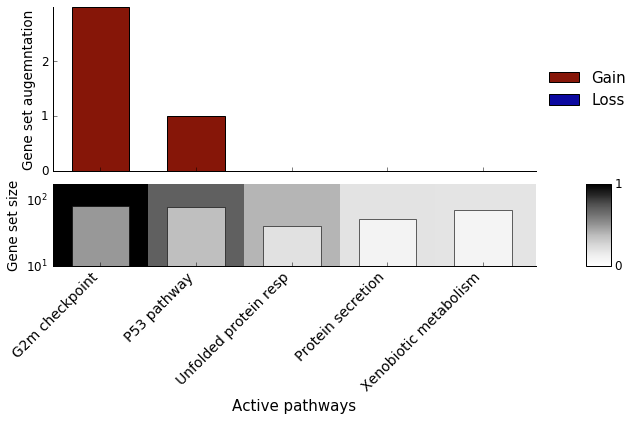

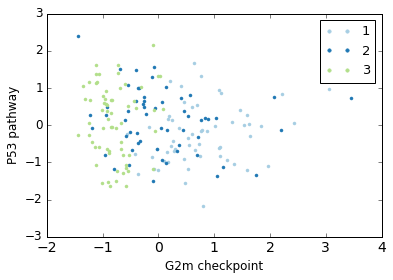

In [5]:
#plot resutls
fig = plotFA(FA)

#get factors; analogous getters are implemented for relevance and weights (see docs)
X = FA.getFactors(ids=['G2m checkpoint','P53 pathway'])

#scatter plot of the top two factors
plotFactors(X=X, lab=data['lab'], terms=['G2m checkpoint','P53 pathway'], isCont=False)


#the same plot can be generated by passing the FA object to the plot function
#plotFactors(FA=FA,idx1=0,idx2=1, lab = data['lab'], isCont=False )



In [6]:
#get changes genes ? 
changed=FA.getNchanged()
#explore changes to G2M checkpoint factor


Finally, we can safe the model results as CSV files or using a .hdf5 file.

In [9]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out_file_name = os.path.join(out_dir,FA.getName()+'.hdf5')
saveFA(FA, out_name=out_file_name)